This sample notebook shows how different types of network analysis operations can be performed using the ArcGIS API for Python.

## Creating a connection to an ArcGIS Online organization

First, you would need to establish a connection to your organization which could be an ArcGIS Online organization or an ArcGIS Enterprise. To be able to run the code in this sample notebook, you would need to provide credentials of a user within an ArcGIS Online organization.

In [1]:
from copy import deepcopy
from datetime import datetime
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding

user_name = 'arcgis_python'
password = 'P@ssword123'
my_gis = GIS('https://www.arcgis.com', user_name, password)

## Creating a network analysis layer

Thereafter, you would need to create a `NetworkLayer` object which is used for operations such as finding the closest facility, the best route between multiple stops, or service area around a facility. To create a `NetworkLayer` object which you would use later for network analysis, you would need to provide the URL to the network analysis service. However, since all ArcGIS Online organizations already have access to those routing services, you can access this URL through the `GIS` object. If you have your own ArcGIS Server based map service with network analysis capability enabled, you would need to provide the REST end point URL for this service.

### Creating a `RouteLayer` layer

In [2]:
route_service_url = my_gis.properties.helperServices.route.url
route_service_url

'https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World'

In [3]:
route_service = network.RouteLayer(route_service_url, gis=my_gis)
route_service

<RouteLayer url:"https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World">

ArcGIS Online Premium Routing services have [worldwide coverage](https://resources.arcgis.com/en/help/arcgis-rest-api/#/Network_analysis_coverage/02r300000034000000/) which means that you don't have to worry about specifying the analysis region as the service will automatically calculate the region name based on the location of the input points.

<Item title:"ArcGIS Online Directions and Routing Services Coverage" type:Web Map owner:esri>
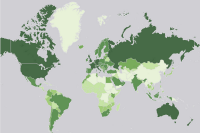

In [4]:
my_gis.content.search('title: ArcGIS Online Directions and Routing Services Coverage type:Web Map owner:esri',
                      item_type='Web Map', outside_org=True)[0]

ArcGIS Online also provides access to the traffic map service which you can use to visualize real time traffic speeds and incidents such as accidents, construction sites, or street closures. Traffic visualization displays information about how travel speeds on specific road segments change over time.

<Item title:"World Traffic Map" type:Web Map owner:esri>
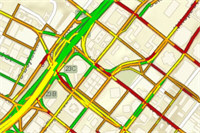

In [5]:
my_gis.content.search('title: World Traffic Map type:Web Map owner:esri',
                      item_type='Web Map', outside_org=True)[0]

## Calculating the total distance and travel time between two stops using the coordinates pairs, addresses and JSON data

To solve the route between multiple stops, you would need to provide the coordinates for the input stops. The set of stops is loaded as network locations during analysis. Stops can be specified using a simple comma / semi-colon based syntax or as a JSON structure. 

Depending on what information you need to get returned from the `solve()` method, you can access the returned JSON object and retrieve the necessary details. Since in this particular case we are not interested in getting the route directions or the route shape, we will set those parameters to `False` to speed up the process of result generation. 

To learn more about the parameters of the `RouteLayer.solve()` method, please refer to the ArcGIS REST API Help page [Route service with synchronous execution](https://resources.arcgis.com/en/help/arcgis-rest-api/#/Route_service_with_synchronous_execution/02r300000036000000/).

In this example, we have specified the stops coordinates in the latitude/longitude format. The `result` object returned from the service is a Python dictionary which makes it very easy to access the needed information about the solved route.

In [6]:
route_layer = network.RouteLayer(route_service_url, gis=my_gis)
result = route_layer.solve(stops='''18.068598,59.329268; 18.068598,59.429268''',
                           returnDirections=False, returnRoutes=True, 
                           outputLines='esriNAOutputLineNone',
                           returnBarriers=False, returnPolygonBarriers=False, 
                           returnPolylineBarriers=False)

travel_time = result['routes']['features'][0]['attributes']['Total_TravelTime']
print("Total travel time is {0:.2f} min".format(travel_time))

Total travel time is 18.29 min


ArcGIS API for Python also provides access to the geocoding functionality available within your ArcGIS Online Organization or ArcGIS Enterprise. So, if your input data doesn't come as pairs of coordinates, you could geocode the input addresses and then pass the coordinates to the `solve()` method:

In [7]:
stop1_address = '1200 E Colton Ave, Redlands, CA 92374'
stop2_address = '11711 Sand Canyon Rd, Yucaipa, CA 92399'

stop1_geocoded = geocoding.geocode(stop1_address)
stop2_geocoded = geocoding.geocode(stop2_address)

stops = '{0},{1}; {2},{3}'.format(stop1_geocoded[0]['attributes']['X'],
                                  stop1_geocoded[0]['attributes']['Y'],
                                  stop2_geocoded[0]['attributes']['X'],
                                  stop2_geocoded[0]['attributes']['Y'])

route_layer = network.RouteLayer(route_service_url, gis=my_gis)
result = route_layer.solve(stops=stops, returnDirections=False, returnRoutes=True, 
                           outputLines='esriNAOutputLineNone', returnBarriers=False, 
                           returnPolygonBarriers=False, returnPolylineBarriers=False)

travel_time = result['routes']['features'][0]['attributes']['Total_TravelTime']
print("Total travel time is {0:.2f} min".format(travel_time))

Total travel time is 7.98 min


In other cases, your input stops coordinates may be stored using another spatial reference or you may need to pass in additional information about your stops such as names or wait times. In this example, we are passing the input stops in the JSON format with stops' coordinates defined using the Web Mercator coordinate system. This example would be helpful if you store your stops in another system and can programmatically read the stops and parse JSON.

In [8]:
route_layer = network.RouteLayer(route_service_url, gis=my_gis)
input_stops = json.loads('''{"features": [
{"geometry": {"x": -13108894.078499999, "y": 4034551.2082, 
"spatialReference": {"wkid":3857, "latestWkid":3857}},
"attributes": {"Name": "945 Azalea Dr, Pomona, California"}}, 
{"geometry": {"x": -13105731.496399999, "y": 4038487.7151999995, 
"spatialReference": {"wkid":3857, "latestWkid":3857}},
"attributes": {"Name":"1321 Loranne Ave, Pomona, California"}}]}''')

result = route_layer.solve(stops=input_stops, returnDirections=False, returnRoutes=True, 
                           outputLines='esriNAOutputLineNone', returnBarriers=False, 
                           returnPolygonBarriers=False, returnPolylineBarriers=False)

total_distance = result['routes']['features'][0]['attributes']['Total_Kilometers']
print("Total distance is {0:.2f} km".format(total_distance))

Total distance is 5.89 km


## Getting the directions between two stops applying the style

The `solve()` operation can also optionally return the directions which you would see when using the Directions widget in the Web App Builder, in the ArcGIS Online map viewer, or when building your own custom web app using the ArcGIS API for JavaScript. The directions object can be loaded into an HTML object to be printed, but it can also be loaded into a `pandas` data frame and presented as a table for reference purposes.

In this example, we have specified the stops coordinates in the latitude/longitude format.

In [9]:
stops = '''-3.203062,55.906437; -3.190080,55.935570'''

As the ArcGIS Online routing service is traffic aware, one can specify the start time of the departure to get the most accurate travel time. In this example, we will pass as the start time the current time (UTC).

In [10]:
start_time = int(datetime.datetime.utcnow().timestamp() * 1000)

route_layer = network.RouteLayer(route_service_url, gis=my_gis)
result = route_layer.solve(stops=stops, 
                           directionsLanguage='en-US', returnRoutes=False,
                           returnStops=False, returnDirections=True,
                           directionsLengthUnits='esriNAUKilometers',
                           returnBarriers=False, returnPolygonBarriers=False,
                           returnPolylineBarriers=False, startTime=start_time,
                           startTimeIsUTC=True)

### Creating a `pandas` data frame from returned directions

After the result object is returned, we would create a table formatted directions panel which would include the information on when the route started, the duration and distance of every segment in the route as well as the direction text.

In [11]:
records = []
travel_time, time_counter = 0, 0
distance, distance_counter = 0, 0

for i in result['directions'][0]['features']:
    time_of_day = datetime.datetime.fromtimestamp(i['attributes']['arriveTimeUTC'] / 1000).strftime('%H:%M:%S')
    time_counter = i['attributes']['time']
    distance_counter = i['attributes']['length']
    travel_time += time_counter
    distance += distance_counter
    records.append( (time_of_day, i['attributes']['text'], 
                     round(travel_time, 2), round(distance, 2))  )    

In [12]:
pd.set_option('display.max_colwidth', 100)
df = pd.DataFrame.from_records(records, index=[i for i in range(1, len(records) + 1)], 
                               columns=['Time of day', 'Direction text', 
                                        'Duration (min)', 'Distance (km)'])
HTML(df.to_html(index=False))

Time of day,Direction text,Duration (min),Distance (km)
23:09:57,Start at Location 1,0.00,0.00
23:09:57,Go northwest on Buckstone Place toward Buckstone Road,0.61,0.09
23:10:34,Turn left on Buckstone Road,1.34,0.38
23:11:18,Turn right on Buckstone Terrace (A702),1.84,0.66
23:11:48,Make sharp right on Braid Road,3.86,2.03
23:13:49,Turn right on Hermitage Drive,4.44,2.41
23:14:24,Turn left on Braid Avenue,5.19,2.84
23:15:08,Turn right on Cluny Gardens,6.25,3.54
23:16:12,Turn left on Oswald Road,7.20,4.04
23:17:09,Turn left on Kilgraston Road,8.27,4.60


### Creating HTML from returned directions

If you would need to pass the returned directions to another system which expects to receive an HTML object, you can apply custom formating to the directions object. This is done by using the IPython built-in `HTML` object and the `display()` method.

In [13]:
td_data = ['<td align="left">{:s}</td> \
           <td align="left">{:s}</td> \
           <td align="left">{:.2f}</td> \
           <td align="left">{:.2f}</td>'.format(*values) 
           for values in records]
tr_data = ['<tr>{}</tr>'.format(i) for i in td_data]

display(HTML('<table> \
             <tr> <th> Time of day </th> \
             <th>Instruction</th> \
             <th>Time</th> \
             <th>Distance</th> </tr> {0} </table>'.format(''.join(tr_data))))

Time of day,Instruction,Time,Distance
23:09:57,Start at Location 1,0.00,0.00
23:09:57,Go northwest on Buckstone Place toward Buckstone Road,0.61,0.09
23:10:34,Turn left on Buckstone Road,1.34,0.38
23:11:18,Turn right on Buckstone Terrace (A702),1.84,0.66
23:11:48,Make sharp right on Braid Road,3.86,2.03
23:13:49,Turn right on Hermitage Drive,4.44,2.41
23:14:24,Turn left on Braid Avenue,5.19,2.84
23:15:08,Turn right on Cluny Gardens,6.25,3.54
23:16:12,Turn left on Oswald Road,7.20,4.04
23:17:09,Turn left on Kilgraston Road,8.27,4.60


## Drawing the result route on a web map as a layer

The `solve()` method can also return the geometry of the route between the stops. The geometry can be added as a graphics to your web map and drawn interactively in the notebook. The solved route as well as the input stops can optionally have a pop-up window configured to include the key information.

In this example, we have again specified the stops coordinates in the latitude/longitude format.

In [14]:
stops = '''-3.203062,55.906437; -3.190080,55.935570'''

route_layer = network.RouteLayer(route_service_url, gis=my_gis)
result = route_layer.solve(stops=stops, 
                           directionsLanguage='en-US', returnRoutes=True,
                           returnStops=True, returnDirections=False,
                           returnBarriers=False, returnPolygonBarriers=False,
                           returnPolylineBarriers=False)

In [15]:
my_map = my_gis.map('Braidburn Valley', zoomlevel=13)

![my_map](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_na_performing_route_analyses_01.png)

In the code below, we would reverse geocode the input stops to enrich the pop-ups of stops with the address information as well as apply custom formatting to the `pandas` data frame to draw it's contents within the pop-up windows both for the route and the stops.

In [16]:
my_map.clear_graphics()
stop_count = result['routes']['features'][0]['attributes']['StopCount']
travel_time = result['routes']['features'][0]['attributes']['Total_TravelTime']
distance = result['routes']['features'][0]['attributes']['Total_Kilometers']

data = [('Number of stops', stop_count),
        ('Total travel time', '{0:.2f} min'.format(travel_time)),
        ('Total travel distance', '{0:.2f} km'.format(distance))]

df = pd.DataFrame.from_records(data)
styles = [    
    dict(selector="td", props=[("padding", "2px")]),
    dict(selector='.row_heading, .blank', props=[('display', 'none;')]),
    dict(selector='.col_heading, .blank', props=[('display', 'none;')])]

symbol = {
    "type": "esriSLS",
    "style": "esriSLSSolid",
    "color": [128,0,128,90],
    "width": 4
}

popup_route = {"title": "Route", 
               "content": df.style.set_table_styles(styles).render()}
popup_stop = {"title": "Stop {}", 
              "content": df.style.set_table_styles(styles).render()}

my_map.draw(result['routes']['features'][0]['geometry'], popup_route, symbol)

for stop in result['stops']['features']:
    address = geocoding.reverse_geocode(stop['geometry'])['address']['Match_addr']
    my_map.draw(stop['geometry'], 
                {"title": "Stop {}".format(stop['attributes']['Sequence']), 
                 "content": address})
my_map.zoom = 12

Click the stops markers as well as the route polyline to explore their attributes. Because the content of the pop-ups may include HTML source code, it is also possible to have the pop-up windows include other resources such as tables and images.

## Solving multiple routes

In this example, we will solve multiple routes by reading a `.csv` file which contains the start/end coordinates for each route. The `.csv` file looks as below:

|Start_X|Start_Y|End_X|End_Y|RouteName|
|:---|:---|:---|:---|:-------------------------------|
|34.032885| -117.875613| 33.950965| -118.007080| Route11 |
|34.1032324| -118.0830204| 33.961414| -118.215706| Route22 |
|34.015697| -118.359059| 33.890443| -118.336239| Route33 |
|34.197766| -118.639790| 34.251779| -118.500158| Route44 |
|34.254439| -118.771523| 34.188270| -119.032007| Route55 |

We will read the `.csv` file into a `pandas` data frame which we will later enrich with the travel time and distance.

In [17]:
df = pd.read_csv(r'C:\Data\routes.csv')
df['TravelTime'], df['Distance'] = None, None
df

,Start_X,Start_Y,End_X,End_Y,RouteName,TravelTime,Distance
0,34.032885,-117.875613,33.950965,-118.007080,Route11,None,None
1,34.103232,-118.083020,33.961414,-118.215706,Route22,None,None
2,34.015697,-118.359059,33.890443,-118.336239,Route33,None,None
3,34.197766,-118.639790,34.251779,-118.500158,Route44,None,None
4,34.254439,-118.771523,34.188270,-119.032007,Route55,None,None


In [18]:
route_layer = network.RouteLayer(route_service_url, gis=my_gis)

for idx, values in df.iterrows():
    stops = '{0},{1}; {2},{3}'.format(values['Start_Y'], values['Start_X'], 
                                      values['End_Y'], values['End_X'])
    result = route_layer.solve(stops=stops)['routes']['features'][0]['attributes']
    df.loc[idx, 'TravelTime'] = result['Total_TravelTime']
    df.loc[idx, 'Distance'] = result['Total_Kilometers']

df

,Start_X,Start_Y,End_X,End_Y,RouteName,TravelTime,Distance
0,34.032885,-117.875613,33.950965,-118.007080,Route11,21.7414,21.0819
1,34.103232,-118.083020,33.961414,-118.215706,Route22,31.0056,26.1765
2,34.015697,-118.359059,33.890443,-118.336239,Route33,21.1058,19.8738
3,34.197766,-118.639790,34.251779,-118.500158,Route44,23.5477,20.1751
4,34.254439,-118.771523,34.188270,-119.032007,Route55,30.632,36.9144


### Solving the traveling salesperson problem (TSP)

In this example, we will solve the traveling salesperson problem (TSP). For this scenario, we will have one single input address which will be used both as the start and the end point. The orders' locations will be loaded from a feature layer hosted within an ArcGIS Online organization. However, the orders location could also come from a `.csv` file, an ArcGIS Server feature service or from a disk-based data source such a shapefile or a geodatabase feature class.

To be able to solve the TSP, you should specify `True` for the `findBestSequence` parameter. The `True` parameter value causes the service to switch from solving a shortest-path problem to a traveling salesperson problem. 

> **Note** Keep in mind that solving a TSP is computer-intensive operation and incurs additional service credits per route.

<Item title:"USA Major Cities" type:Feature Service owner:esri>
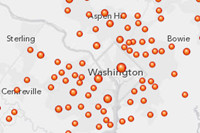

In [19]:
sample_cities = my_gis.content.search('title:"USA Major Cities" type:Feature Service owner:esri', 
                                      outside_org=True)[0]
sample_cities

In [20]:
office_address = '380 New York St, Redlands, CA 92373'

In [21]:
fl = sample_cities.layers[0]
cities_to_visit = fl.query(where="ST = 'CA' AND POP2007 > 300000", 
                           out_fields='NAME', out_sr=4326)

office_coords = geocoding.geocode(office_address)[0]['attributes']
office_feature = {'geometry': {'x': office_coords['X'], 
                               'y': office_coords['Y']}, 
                  'attributes': {'Name': office_address}
                 }

cities_features = deepcopy(cities_to_visit.features)
cities_features.insert(0, office_feature)
cities_features.append(office_feature)

For this particular scenario, we are only interested in finding out the best sequence of visiting the stops; we are not interested in the route directions. However, as we want to draw the lines connecting the order points for visualization purposes only, we need to specify an appropriate value for the `outputLines` parameter. 

In [22]:
route_layer = network.RouteLayer(route_service_url, gis=my_gis)
result = route_layer.solve(stops={'features': cities_features}, preserveFirstStop=True, 
                           preserveLastStop=True, findBestSequence=True, returnDirections=False, 
                           returnStops=True, returnBarriers=False, returnPolygonBarriers=False, 
                           returnPolylineBarriers=False, returnRoutes=True, 
                           outputLines='esriNAOutputLineStraight')

In [23]:
my_map = my_gis.map('Santa Maria, CA', zoomlevel=6)

![my_map](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_na_performing_route_analyses_02.png)

In [24]:
my_map.clear_graphics()
my_map.draw(result['routes']['features'][0]['geometry'])

sequence_symbol = {
     "type": "esriTS",
     "color": [255,255,255,255],
     "backgroundColor": [0,0,0,0],
     "borderLineSize": 2,
     "borderLineColor": [255,0,255,255],
     "haloSize": 2,
     "haloColor": [0,0,0,255],
     "verticalAlignment": "bottom",
     "horizontalAlignment": "left",
     "rightToLeft": False,
     "angle": 0,
     "xoffset": 0,
     "yoffset": 0,
     "kerning": True,
     "font": {
      "family": "Segoe UI",
      "size": 9,
      "style": "normal",
      "weight": "bold",
      "decoration": "none"
     },
    "text": ""
}

for i in result['stops']['features'][0:-1]:
    sequence_symbol['text'] = i['attributes']['Sequence']
    my_map.draw(i['geometry'], symbol=sequence_symbol)

sequence_symbol['xoffset'] = 10
sequence_symbol['yoffset'] = 0
sequence_symbol['text'] = ' | {}'.format(len(result['stops']['features']))
my_map.draw(result['stops']['features'][-1]['geometry'], symbol=sequence_symbol)

The solved sequence of stops can also be presented in a table form for reference purposes.

In [25]:
records = []
for i in sorted(result['stops']['features'], key=lambda x: (x['attributes']['Sequence'])):
    records.append((i['attributes']['Name'], i['attributes']['Sequence'] ))
pd.DataFrame.from_records(records, columns=['Location', 'Sequence'])

,Location,Sequence
0,"380 New York St, Redlands, CA 92373",1
1,San Jose,2
2,San Francisco,3
3,Oakland,4
4,Sacramento,5
5,Fresno,6
6,Los Angeles,7
7,Long Beach,8
8,Anaheim,9
9,Santa Ana,10
